# DR V1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from pathlib import Path
import cv2
import time
import random
from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All Libraries Imported Successfully")

All Libraries Imported Successfully


In [2]:
image_dir = Path('/kaggle/input/diabetic-retinopathy-224x224-2019-data')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head()

,Filepath,Label
0,/kaggle/input/diabetic-retinopathy-224x224-201...,No_DR
1,/kaggle/input/diabetic-retinopathy-224x224-201...,Moderate
2,/kaggle/input/diabetic-retinopathy-224x224-201...,Moderate
3,/kaggle/input/diabetic-retinopathy-224x224-201...,No_DR
4,/kaggle/input/diabetic-retinopathy-224x224-201...,No_DR


In [4]:
original_image_dir = Path('/kaggle/input/diabetic-retinopathy-224x224-2019-data')
preprocessed_image_dir = Path('/kaggle/working/Preprocessed_Images')

preprocessed_image_dir.mkdir(parents=True, exist_ok=True)


filepaths = list(original_image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths_series = pd.Series(filepaths, name='Filepath').astype(str)
labels_series = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths_series, labels_series], axis=1)

# Apply Gaussian filter
for index, row in image_df.iterrows():
    image_path = row['Filepath']
    
    image = cv2.imread(str(image_path))
    
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    new_image_path = preprocessed_image_dir / Path(image_path).name

    cv2.imwrite(str(new_image_path), blurred_image)
    
    image_df.at[index, 'Filepath'] = str(new_image_path)

image_df = image_df.sample(frac=1).reset_index(drop=True)
image_df.head()

,Filepath,Label
0,/kaggle/working/Preprocessed_Images/a763661f98...,Severe
1,/kaggle/working/Preprocessed_Images/6504b703c4...,No_DR
2,/kaggle/working/Preprocessed_Images/bb733062f4...,Moderate
3,/kaggle/working/Preprocessed_Images/4464bb62bf...,No_DR
4,/kaggle/working/Preprocessed_Images/c24bcf7a1b...,No_DR


In [5]:
level = []
for i in image_df['Label']:
    if i=='No_DR':
        level.append(0)
    elif i=='Mild':
        level.append(1)
    elif i=='Moderate':
        level.append(2)
    elif i=='Severe':
        level.append(3)
    else:
        level.append(4)
image_df['Level'] = level

In [6]:
image_df.head()

,Filepath,Label,Level
0,/kaggle/working/Preprocessed_Images/a763661f98...,Severe,3
1,/kaggle/working/Preprocessed_Images/6504b703c4...,No_DR,0
2,/kaggle/working/Preprocessed_Images/bb733062f4...,Moderate,2
3,/kaggle/working/Preprocessed_Images/4464bb62bf...,No_DR,0
4,/kaggle/working/Preprocessed_Images/c24bcf7a1b...,No_DR,0


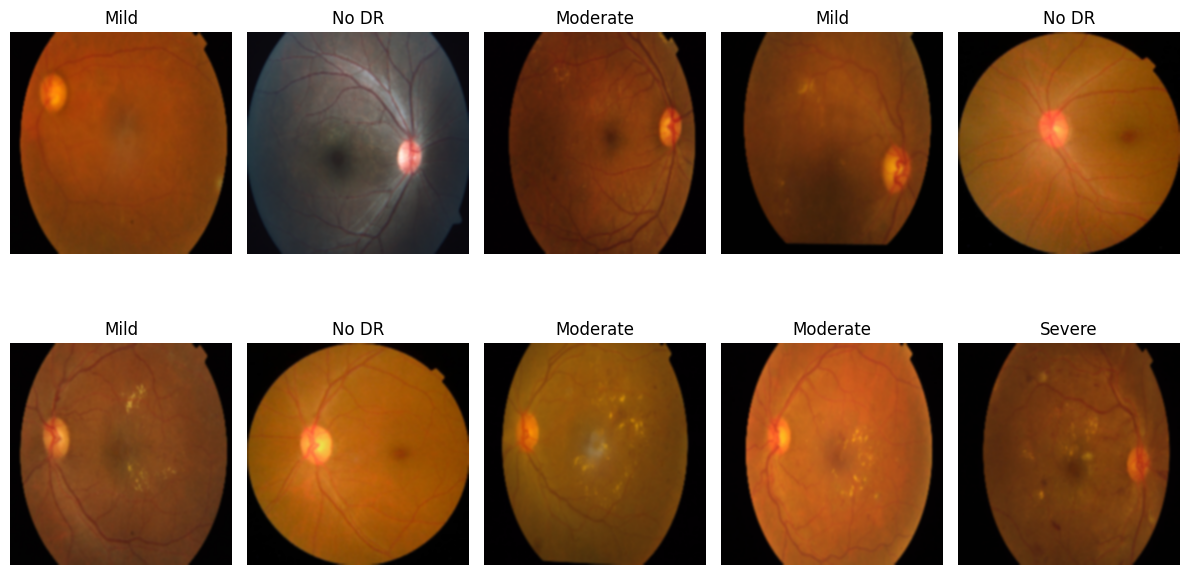

In [7]:
plt.figure(figsize=(12, 7))

for i in range(10):
    sample = random.choice(range(len(image_df)))
    
    # Access the correct columns
    image_path = image_df.iloc[sample]['Filepath']  # Path to image
    category = image_df.iloc[sample]['Level']        # Label

    # Check if image_path is a string
    if not isinstance(image_path, str):
        print(f"Error: Expected image path to be a string, but got {type(image_path)}")
        continue
    
    try:
        # Open and show the image
        image = Image.open(image_path)
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        continue

    # Define labels
    label_names = {
        0: "No DR",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        4: "Proliferate DR"
    }

    label = label_names.get(category, "Unknown")

    plt.subplot(2, 5, i + 1)  
    plt.imshow(image)
    plt.title(label)  # Use title instead of xlabel for clarity
    plt.axis('off')   # Hide axes for better visualization

plt.tight_layout()
plt.show()


In [8]:
import cv2
X = []
for i in image_df['Filepath']:
    image = cv2.imread(i)
    X.append(image)
    
X = np.asarray(X)
y = image_df['Level']
Y = np.asarray(y)

In [9]:
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

2563 769 330


In [10]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2563, 224, 224, 3)
(769, 224, 224, 3)
(330, 224, 224, 3)


In [11]:
idg_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

idg_test = ImageDataGenerator(rescale=1./255)

In [12]:
idg_train.fit(x_train)
idg_train.fit(x_val)
idg_test.fit(x_test)

In [13]:
# Create generators
train_generator = idg_train.flow(x_train, y_train, batch_size=32)
validation_generator = idg_test.flow(x_val, y_val, batch_size=32)
test_generator = idg_test.flow(x_test, batch_size=32, shuffle=False)


In [14]:
early_stopping_callback = EarlyStopping(
    monitor='loss',
    patience=15,
    verbose = 1,
    restore_best_weights=True,
    mode = 'min'
)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_generator = idg_test.flow(x_test, y_test, batch_size=32, shuffle=False)


In [16]:
from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)



In [17]:
import tensorflow as tf

def create_dataset(x, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.batch(batch_size)
    return dataset

# Create datasets
train_dataset = create_dataset(x_train, y_train, batch_size=32)
val_dataset = create_dataset(x_val, y_val, batch_size=32, shuffle=False)
test_dataset = create_dataset(x_test, y_test, batch_size=32)


In [20]:
dnn_model = Sequential()
dnn_model.add(Flatten(input_shape=(224, 224, 3)))
dnn_model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dropout(0.2))

dnn_model.add(Dense(5, activation='softmax'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compile the model with sparse categorical crossentropy
dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = dnn_model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping_callback]
)

Epoch 1/40


I0000 00:00:1728391304.956126     113 service.cc:145] XLA service 0x7d4b2c00a270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728391304.956203     113 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728391304.956209     113 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


23/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3516 - loss: 2.0366

I0000 00:00:1728391314.258395     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.4826 - loss: 1.6309 - val_accuracy: 0.5007 - val_loss: 1.2294
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6636 - loss: 1.0098 - val_accuracy: 0.6021 - val_loss: 1.0357
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6451 - loss: 0.9702 - val_accuracy: 0.6164 - val_loss: 0.9798
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6708 - loss: 0.9345 - val_accuracy: 0.7061 - val_loss: 0.8894
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6824 - loss: 0.8865 - val_accuracy: 0.6801 - val_loss: 0.9269
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6648 - loss: 0.9342 - val_accuracy: 0.7230 - val_loss: 0.9169
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6995 - loss: 0.8395 - val_accuracy: 0.7152 - val_loss: 1.0444
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6789 - loss: 0.9232 - val_accuracy: 0.7087 - val_loss: 1.1235


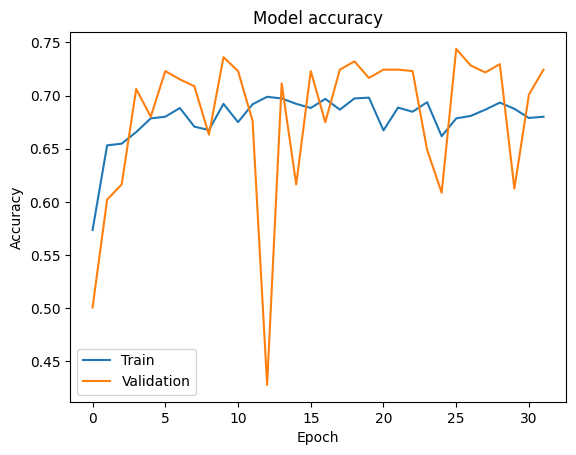

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [23]:
train_loss, train_accuracy = dnn_model.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

val_loss, val_accuracy = dnn_model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = dnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 67.58%
Validation Accuracy: 67.49%
Test Accuracy: 65.15%


In [24]:
y_pred = []
for i in dnn_model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
[0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,

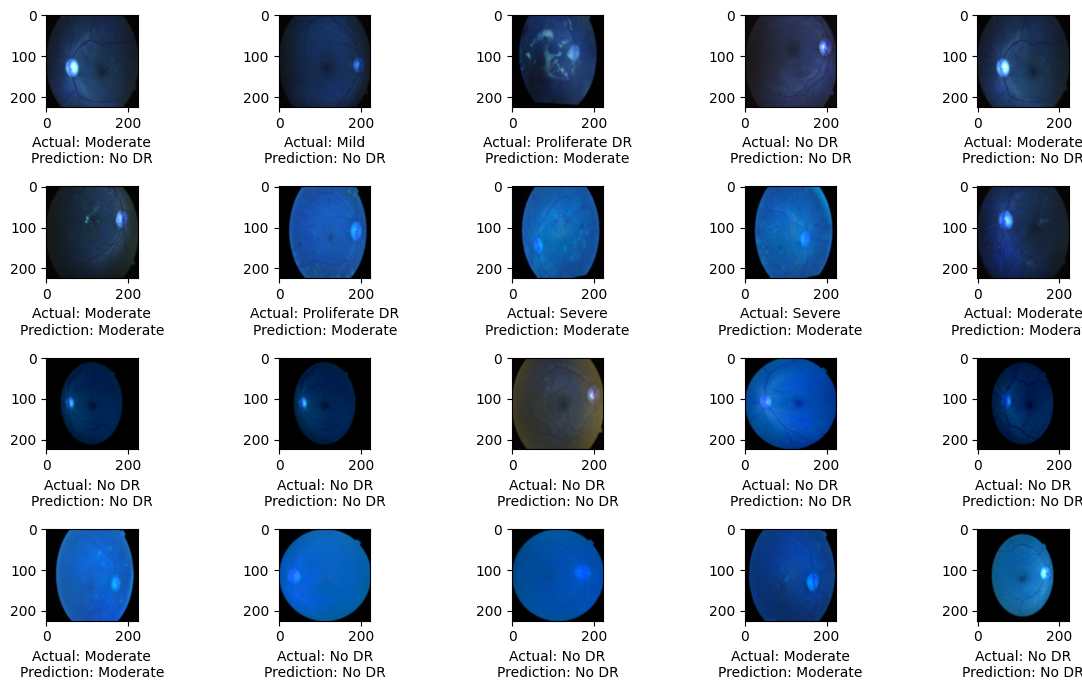

In [25]:
plt.figure(figsize=(12, 7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    label_mapping = {
        0: "No DR",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        4: "Proliferate DR"
    }

    label = label_mapping[category]
    pred_label = label_mapping[pred_category]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label))
plt.tight_layout()
plt.show()

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate per-class metrics
precision1 = precision_score(y_test, y_pred, average=None)
recall1 = recall_score(y_test, y_pred, average=None)
f11 = f1_score(y_test, y_pred, average=None)
mcc1 = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))

print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.68803419 0.25       0.57608696 0.         0.        ]
Recall per class: [0.98773006 0.03333333 0.64634146 0.         0.        ]
F1 Score per class: [0.81108312 0.05882353 0.6091954  0.         0.        ]
Specificity per class: [0.562874251497006, 0.99, 0.842741935483871, 1.0, 1.0]
Cohen's Kappa Score: 0.3985164991916822
Matthews Correlation Coefficient (MCC): 0.4350391616267397


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DR V2

In [1]:
from fastai.vision import *
import os
from fastai.vision import *
import os
os.makedirs('/root/.cache/torch/checkpoints')



In [2]:
!cp ../input/resnet34fastai/resnet34.pth /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth

In [3]:
model_path = 'models'
plot_path = 'plots'

if not os.path.exists(model_path):
    os.makedirs(model_path)
    os.makedirs(os.path.join(model_path, plot_path))

In [4]:
'''
Severity Levels

0 - 'No_DR',
1 - 'Mild',
2 - 'Moderate',
3 - 'Severe',
4 - 'Proliferate_DR'
'''

classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

In [5]:
path = r'../input/diabetic-retinopathy-224x224-2019-data/colored_images'
# path.ls()

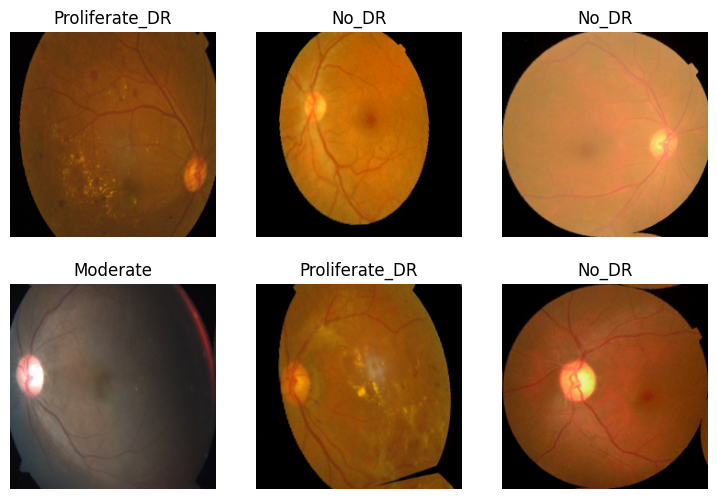

In [6]:
from fastai.vision.all import *

# Set the seed for reproducibility
np.random.seed(42)

# Define the path to your dataset
path = Path('../input/diabetic-retinopathy-224x224-2019-data/colored_images')

# Create DataLoaders
data = ImageDataLoaders.from_folder(
    path,
    train='.',  # The location of the training data
    valid_pct=0.2,  # Percentage of data to use for validation
    item_tfms=Resize(224),  # Resize images to 224x224
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],  # Apply augmentations and normalization
    bs=32  # Batch size
)

# Check if the DataLoaders are created properly
data.show_batch(max_n=6)


In [7]:
# Assuming dls is your ImageDataLoaders object

# Print the class names
print("Classes:", data.vocab)

# Print the number of classes
print("Number of classes:", len(data.vocab))

# Print the number of training samples
print("Number of training samples:", len(data.train_ds))

# Print the number of validation samples
print("Number of validation samples:", len(data.valid_ds))


Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
Number of classes: 5
Number of training samples: 2930
Number of validation samples: 732


In [8]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/kaggle/working/models')

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.8MB/s]


In [9]:
learn.fit_one_cycle(20)    

epoch,train_loss,valid_loss,accuracy,time
0,1.978975,0.965209,0.637978,00:15
1,1.332574,0.764415,0.756831,00:13
2,1.014639,0.684669,0.765027,00:13
3,0.908489,0.631647,0.782787,00:13
4,0.804596,0.652039,0.785519,00:14
5,0.693705,0.583552,0.811475,00:13
6,0.662876,0.566095,0.818306,00:14
7,0.610171,0.515647,0.799180,00:14
8,0.557608,0.543478,0.799180,00:13
9,0.519768,0.524134,0.804645,00:13


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

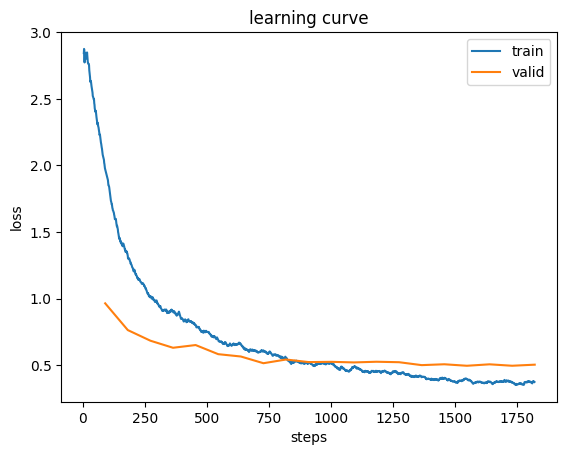

In [10]:
learn.recorder.plot_loss()


In [11]:
!pwd
print(os.listdir('../../'))

/kaggle/working
['bin', 'var', 'mnt', 'etc', 'root', 'home', 'tmp', 'lib', 'sbin', 'proc', 'lib64', 'srv', 'boot', 'opt', 'sys', 'media', 'lib32', 'usr', 'run', 'libx32', 'dev', 'kaggle', '.dockerenv', '.jupyter', '=24.4', 'install_packages.sh', 'libnvinfer8_8.6.1.6-1+cuda12.0_amd64.deb', 'run_jupyter.sh', 'entrypoint.sh', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']


In [12]:
learn.unfreeze()

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=1.2022644114040304e-05)

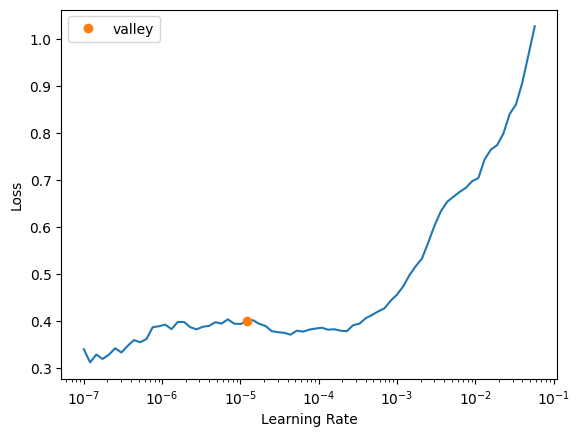

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(10, lr_max=slice(1e-7, 1e-5))


epoch,train_loss,valid_loss,accuracy,time
0,0.375443,0.500102,0.823770,00:19
1,0.371210,0.498284,0.822404,00:19
2,0.366169,0.497828,0.819672,00:19
3,0.356798,0.495176,0.823770,00:19
4,0.374288,0.506444,0.819672,00:19
5,0.347136,0.497280,0.822404,00:19
6,0.373334,0.506217,0.811475,00:19
7,0.390157,0.508114,0.816940,00:19
8,0.369848,0.495808,0.823770,00:19
9,0.361621,0.495759,0.819672,00:19


In [15]:
val_loss, val_acc = learn.validate()

# Print validation metrics
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.4958
Validation Accuracy: 0.8197


In [16]:
learn.unfreeze()
learn.fit_one_cycle(10)  # Fine-tune for additional epochs with more layers unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,0.585545,0.854879,0.758197,00:19
1,0.675437,0.746638,0.725410,00:19
2,0.640518,0.873916,0.739071,00:19
3,0.603768,0.563751,0.812842,00:19
4,0.566488,0.776211,0.736339,00:19
5,0.546890,0.486793,0.818306,00:19
6,0.493552,0.508656,0.808743,00:19
7,0.455170,0.439291,0.831967,00:19
8,0.409969,0.426571,0.834699,00:19
9,0.371848,0.424030,0.840164,00:19


In [17]:
val_loss, val_acc = learn.validate()

# Print validation metrics
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.4240
Validation Accuracy: 0.8402


In [18]:
# Get predictions
preds, y_true = learn.get_preds(dl=data.valid)


In [19]:
# Convert predictions to class labels
pred_labels = preds.argmax(dim=1)
# Get the names of the classes
class_names = data.vocab

# Convert to list of class names
pred_labels = [class_names[i] for i in pred_labels]
y_true_labels = [class_names[i] for i in y_true]


In [20]:
# Create a DataLoader for the validation set
valid_dl = data.valid


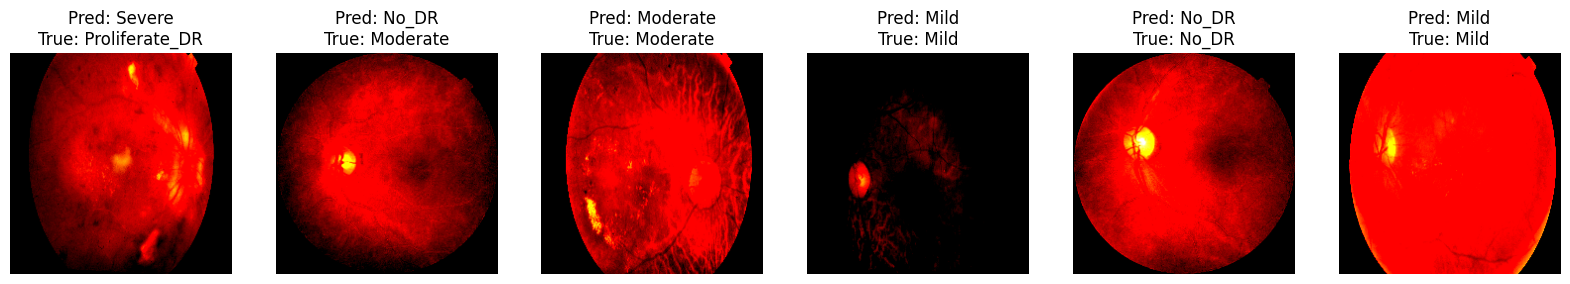

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, preds, true_labels, class_names, num_images=6):
    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax = axs[i]
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        pred_label = preds[i]
        true_label = true_labels[i]
        
        ax.imshow(img)
        ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}')
        ax.axis('off')
    plt.show()

# Get a batch of images and labels
imgs, labels = next(iter(valid_dl))
# Convert to CPU if necessary
imgs = imgs.cpu()
labels = labels.cpu()

# Plot predictions
plot_predictions(imgs, pred_labels[:6], y_true_labels[:6], class_names)


In [22]:
learn.save('FastAiDR')

Path('/kaggle/working/models/FastAiDR.pth')

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

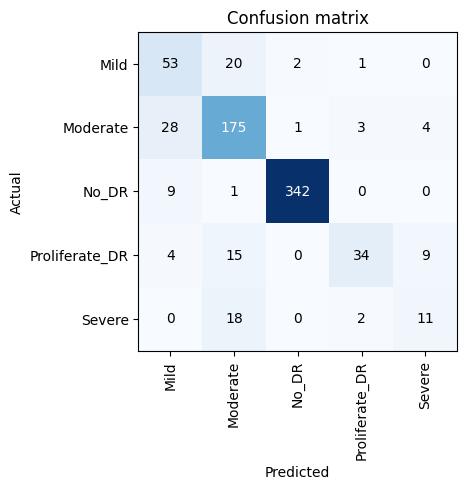

In [24]:
interp.plot_confusion_matrix()

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [71]:
# Get predictions and true labels
pred_probs, true_labels = learn.get_preds(dl=valid_dl)
pred_labels = torch.argmax(pred_probs, dim=1).cpu().numpy()
true_labels = true_labels.cpu().numpy()


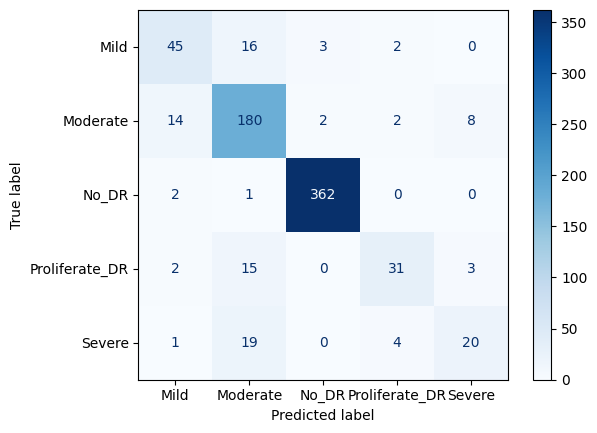

In [72]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(data.vocab))))

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.vocab)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [73]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
import numpy as np

# Get predictions and true labels
preds, targs = learn.get_preds(dl=learn.dls.valid)
preds = preds.argmax(dim=1)  # Get class with highest probability

# Convert to numpy arrays
y_true_classes = targs.numpy()
y_pred_classes = preds.numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# Calculate specificity
specificity = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1 Score per class: {f1}")
print(f"Specificity per class: {specificity}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")


Precision per class: [0.703125   0.77922078 0.98637602 0.79487179 0.64516129]
Recall per class: [0.68181818 0.87378641 0.99178082 0.60784314 0.45454545]
F1 Score per class: [0.69230769 0.82379863 0.98907104 0.68888889 0.53333333]
Specificity per class: [0.9714714714714715, 0.903041825095057, 0.9863760217983651, 0.9882525697503671, 0.9840116279069767]
Cohen's Kappa Score: 0.8015379024303012
Matthews Correlation Coefficient (MCC): 0.8027178589570063


In [27]:
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

# Get predictions and true labels from the Fastai Learner
preds, targs = learn.get_preds(dl=learn.dls.valid)
preds = preds.argmax(dim=1)  # Convert logits to class predictions

# Convert tensors to numpy arrays
y_pred_classes = preds.numpy()
y_true_classes = targs.numpy()

# Calculate classification report
report = confusion_matrix(y_true_classes, y_pred_classes)
print(report)

[[ 53  20   2   1   0]
 [ 28 175   1   3   4]
 [  9   1 342   0   0]
 [  4  15   0  34   9]
 [  0  18   0   2  11]]
